## Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

## Data

In [53]:
# environmental data
env = pd.read_csv('../data-clean/environmental/co2-temp-humidity.csv')
env['datetime'] = pd.to_datetime(env['datetime'], errors='coerce')
env['date'] = env['datetime'].dt.date
env.rename(columns={'Carbon dioxide(ppm)': 'co2'}, inplace=True)
env.rename(columns={'Temperature(°C)': 'temp'}, inplace=True)
env.rename(columns={'Relative humidity(%)': 'humidity'}, inplace=True)
env = env[['device', 'datetime', 'date', 'co2', 'temp', 'humidity']]

# air change rates
aer = pd.read_csv('../data-clean/environmental/air-exchange-rate.csv')

# Mapping dates to intervention periods
map_dates = pd.read_csv("../data-clean/mapping_dates_interventions.csv")

# Merge environmental data with mapping dates
env = env.merge(map_dates, on='date', how='left')
# Merge air exchange rates with mapping dates
aer = aer.merge(map_dates, on='date', how='left')

## Descriptives

### Summary

In [14]:
# Compute median and IQR for co2, temp, and humidity by device
summary_stats = env.groupby('device').agg(
	co2_median=('co2', 'median'),
	co2_Q25=('co2', lambda x: x.quantile(0.25)),
	co2_Q75=('co2', lambda x: x.quantile(0.75)),
	temp_median=('temp', 'median'),
	temp_Q25=('temp', lambda x: x.quantile(0.25)),
	temp_Q75=('temp', lambda x: x.quantile(0.75)),
	humidity_median=('humidity', 'median'),
	humidity_Q25=('humidity', lambda x: x.quantile(0.25)),
	humidity_Q75=('humidity', lambda x: x.quantile(0.75))
).reset_index()

# Print the results
print(summary_stats)

          device  co2_median  co2_Q25  co2_Q75  temp_median  temp_Q25  \
0  Aranet4 25247       380.0    351.0   437.25         22.4      20.8   
1  Aranet4 272D2       455.0    406.0   533.00         23.0      21.3   

   temp_Q75  humidity_median  humidity_Q25  humidity_Q75  
0      23.8             31.0          24.0          39.0  
1      24.4             31.0          24.0          38.0  


In [32]:
# Compute median and IQR for aer_tmb and aer_ssm by device
aer_stats = aer.groupby('device').agg(
	aer_tmb_median=('aer_tmb', 'median'),
	aer_tmb_Q25=('aer_tmb', lambda x: x.quantile(0.25)),
	aer_tmb_Q75=('aer_tmb', lambda x: x.quantile(0.75)),
	aer_ssm_median=('aer_ssm', 'median'),
	aer_ssm_Q25=('aer_ssm', lambda x: x.quantile(0.25)),
	aer_ssm_Q75=('aer_ssm', lambda x: x.quantile(0.75))
).reset_index()

# Print the results
print(aer_stats)

          device  aer_tmb_median  aer_tmb_Q25  aer_tmb_Q75  aer_ssm_median  \
0  Aranet4 25247       13.367916     8.511747    21.065923        7.806749   
1  Aranet4 272D2        8.372568     6.679090    11.484210        7.019234   

   aer_ssm_Q25  aer_ssm_Q75  
0     6.634044    10.856939  
1     6.096900     8.208958  


### CO2 levels

In [30]:
# Choose Aranet4 272D2
env_sub = env[env['device'] == 'Aranet4 272D2']
env_sub = env_sub[['datetime', 'date', 'co2', 'temp', 'humidity']]

# Round datetime to 5 minutes
env_sub['datetime_5min'] = env_sub['datetime'].dt.round('5min')

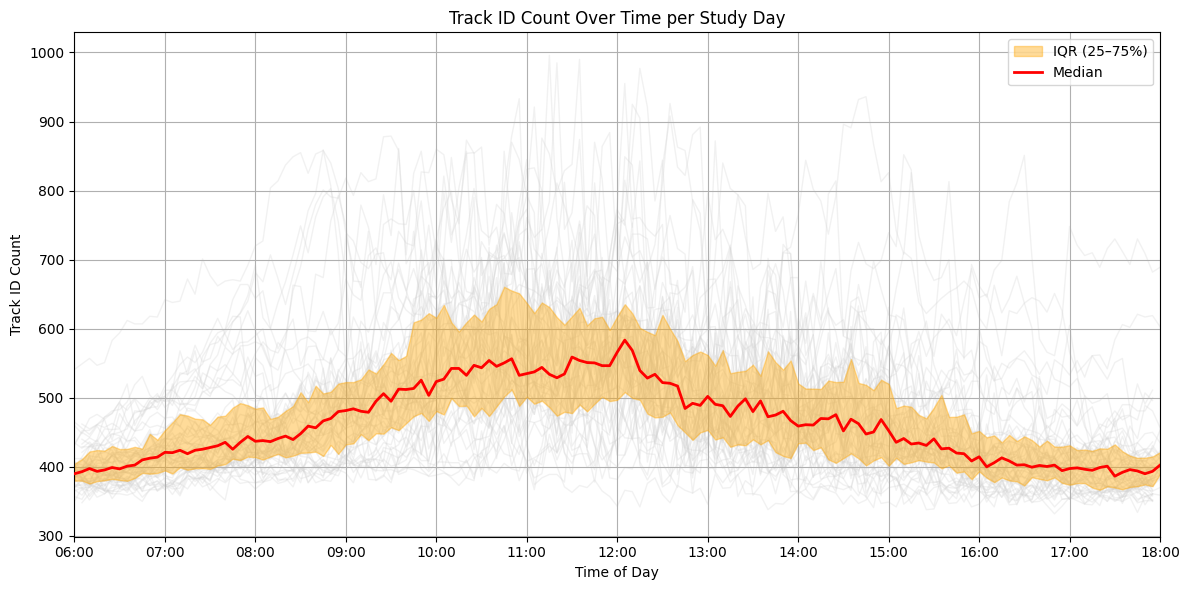

In [31]:
# Reformat datetime
env_sub['minutes_since_midnight'] = env_sub['datetime_5min'].dt.hour * 60 + env_sub['datetime_5min'].dt.minute

# Pivot to get each study day as a column for IQR and median calculation
pivot = env_sub.pivot_table(index='minutes_since_midnight', columns='date', values='co2')

# Compute summary statistics
median_series = pivot.median(axis=1)
q1_series = pivot.quantile(0.25, axis=1)
q3_series = pivot.quantile(0.75, axis=1)

# Filter data from 6am to 6pm
time_mask = (median_series.index >= 360) & (median_series.index <= 1080)
x_vals = median_series.index[time_mask]

# Plotting
plt.figure(figsize=(12, 6))

# Plot all grey lines (faint and behind)
for study_day, group in env_sub.groupby('date'):
    plt.plot(
        group['minutes_since_midnight'],
        group['co2'],
        color='lightgrey',
        alpha=0.3,
        linewidth=1,
        zorder=1
    )

# Plot IQR as shaded area (in front of grey lines)
plt.fill_between(
    x_vals,
    q1_series[time_mask],
    q3_series[time_mask],
    color='orange',
    alpha=0.4,
    label='IQR (25–75%)',
    zorder=2
)

# Plot median line (top layer)
plt.plot(
    x_vals,
    median_series[time_mask],
    color='red',
    linewidth=2,
    label='Median',
    zorder=3
)

# X-axis formatting
plt.xlim(360, 1080)
tick_locs = list(range(360, 1081, 60))  # hourly from 6am to 6pm
tick_labels = [f"{h:02d}:00" for h in range(6, 19)]
plt.xticks(tick_locs, tick_labels)

plt.xlabel('Time of Day')
plt.ylabel('Track ID Count')
plt.title('Track ID Count Over Time per Study Day')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Air exchange rates

In [54]:
# Choose Aranet4 272D2
aer_sub = aer[aer['device'] == 'Aranet4 272D2']

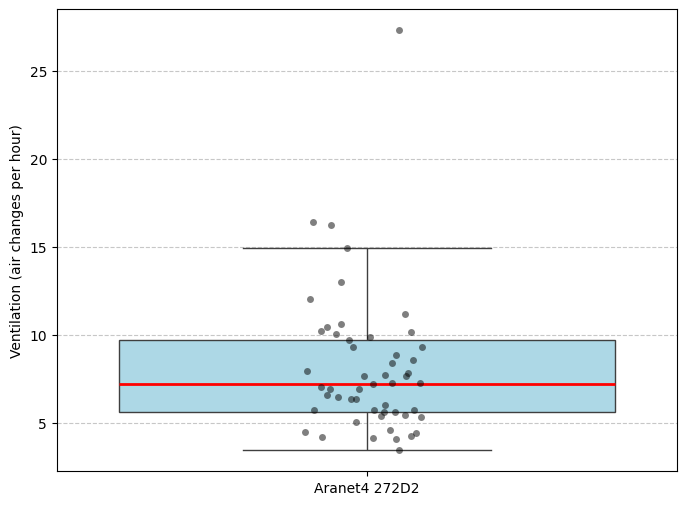

In [58]:
plt.figure(figsize=(8, 6))

# Plot the boxplot without outliers and only showing the median
sns.boxplot(
	x='device', 
	y='aer_tmb', 
	data=aer_sub, 
	showmeans=False, 
	showfliers=False, 
	medianprops={'color': 'red', 'linewidth': 2},
	boxprops={'facecolor': 'lightblue'}
)

# Overlay the observations as dots
sns.stripplot(
	x='device', 
	y='aer_tmb', 
	data=aer_sub, 
	color='black', 
	alpha=0.5, 
	jitter=True
)

plt.xlabel('')
plt.ylabel('Ventilation (air changes per hour)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

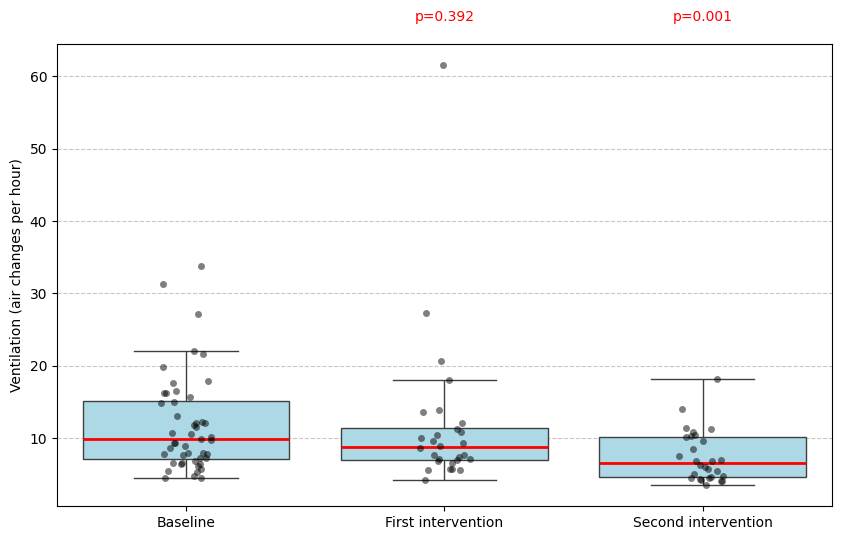

In [60]:
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(
	x='study_phase', 
	y='aer_tmb', 
	data=aer, 
	showmeans=False, 
	showfliers=False, 
	medianprops={'color': 'red', 'linewidth': 2},
	boxprops={'facecolor': 'lightblue'}
)

# Overlay the observations as dots
sns.stripplot(
	x='study_phase', 
	y='aer_tmb', 
	data=aer, 
	color='black', 
	alpha=0.5, 
	jitter=True
)

# Perform Mann-Whitney tests
baseline = aer[aer['study_phase'] == 'Baseline']['aer_tmb']
first_intervention = aer[aer['study_phase'] == 'First intervention']['aer_tmb']
second_intervention = aer[aer['study_phase'] == 'Second intervention']['aer_tmb']
max_value = max(baseline.max(), first_intervention.max(), second_intervention.max())
vjust = 1.1 * max_value

p_first = mannwhitneyu(baseline, first_intervention, alternative='two-sided').pvalue
p_second = mannwhitneyu(baseline, second_intervention, alternative='two-sided').pvalue

# Add p-values to the plot
plt.text(1, vjust, f"p={p_first:.3f}", ha='center', color='red')
plt.text(2, vjust, f"p={p_second:.3f}", ha='center', color='red')

plt.xlabel('')
plt.ylabel('Ventilation (air changes per hour)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()